In [1]:
#########################################################################################
#   Nombre del programa: Cálculo de la radiación solar                                  #
#   Carlos Genes, Luis Miguel Patiño,                                                   #
#########################################################################################
from numpy import arcsin, sin, cos, pi, exp
import numpy as np
import math
from tabulate import tabulate

def angulo_declinacion_solar(dia_juliano):  # Ecuación de declinación solar en unidades de grados
    return 23.45 * sin((2 * pi * (284 + dia_juliano)) / 365)

def angulo_horario(t_solar):  # Ecuación del ángulo horario en unidades de radianes
    return (pi * (t_solar - 12)) / 12

def tiempo_solar(t_local, Eqt, longMS, longLOCAL):  # Ecuación del tiempo solar en unidades de horas
    return t_local + (Eqt / 60) + ((longMS - longLOCAL) / 15)

def Eqt(dia_juliano):  # Algoritmo para hallar ecuación del tiempo en unidades de minutos
    if (1 <= dia_juliano <= 106):
        return -14.2 * sin((pi * (dia_juliano + 7)) / 111)
    elif (167 <= dia_juliano <= 246):
        return -6.5*sin((pi * (dia_juliano - 166)) / 80)
    elif (247 <= dia_juliano <= 365):
        return 16.4 * sin((pi * (dia_juliano - 247)) / 113)

def angulo_elevacion_solar(latitud_geog, angulo_declinacion, angulo_horario):  # Algoritmo para hallar la elevación solar en radianes
    return arcsin(sin(latitud_geog) * sin(angulo_declinacion) + cos(latitud_geog) * cos(angulo_declinacion) * cos(angulo_horario))

def radiacion_solar_extraterrestre_espectral(dia_juliano, angulo_elevacion_solar, s0_espectral): # Algoritmo para hallar la radiación solar extraterrestre espectral #en W/m^2 μm
    # s0_espectral: radiación solar espectral extraterrestre en unidades de W/m² μm
    B = lambda d: (2*pi*d)/365
    f = 1.00011 + 0.034221*cos(B(dia_juliano)) + 0.00128*sin(B(dia_juliano)) + 0.000719*cos(2*B(dia_juliano)) + 0.000077*sin(2*B(dia_juliano))
    return s0_espectral*f*sin(angulo_elevacion_solar)

def transmitancia_R(presion, masa_relativa, cof_dispersion_R): # Algoritmo para hallar transmitancia de Rayleigh
    return exp(-masa_relativa*cof_dispersion_R*(presion/p0)) #Transmitancia de Rayleigh 

def transmitancia_M(presion, masa_relativa, cof_dispersion_M): # Algoritmo para hallar transmitancia de Mie
    return exp(-masa_relativa*cof_dispersion_M*(presion/p0)) #Transmitancia de Mie 

def presion(z): # Expresión para hallar la presión atmosférica en función de la altura
    # El parámetro "z" hace referencia a la altitud (respecto a la superficie) 
    return p0*exp(-0.00012*z) # Presión hPa

def masa_relativa(angulo): #Determina la masa relativa en función del ángulo de incidencia de la radiación
    # El parámetro "angulo" es referente al ángulo respecto al cénit
    return (cos(angulo*a) + 0.15*((93.885-angulo)**(-1.253)))**(-1)
    
def cof_dispersion_R(longitud_de_onda): #Expresión para hallar el coeficiente de dispersión Rayleigh en función de longitud de onda
    return 0.00865*longitud_de_onda**(-(3.916+(0.074*longitud_de_onda)+(0.05/longitud_de_onda))) # Coeficiente de dispersión Rayleigh

def cof_dispersion_M(longitud_de_onda, visibilidad_horz): #Expresión para hallar el coeficiente de dispersión de Mie en función de longitud de onda y la visibilidad horizontal
    beta = (0.55**(1.3))*((3.912/visibilidad_horz)-0.01162)*((0.02472*(visibilidad_horz-5))+1.132) #Factor de turbidez
    return beta*longitud_de_onda**(-1.3) # Coeficiente de dispersión de Mie

def transmitancia_absor_O3(k_O3, l, angulo): #Expresión que calcula transmitancia de absorción por ozono
    # k_O3: coeficiente volumétrico de absorción del ozono espectral
    # l: factor para adimensionar, relacionado con la cantidad de gas ozono que hay presente
    # angulo: es referente al cénit del observador
    z = 0 # altura (se establece a nivel de superficie)
    m_O3 = (1+(z/R_t))/((cos(angulo*a)**2 + 2*(z/R_t))**(1/2))
    return exp(-k_O3*l*m_O3)
    
def transmitancia_absor_mg(k_mg, masa_relativa, presion): #Expresión que calcula transmitancia de absorción por mezcla de gases
    # k_mg: coeficiente volumétrico de absorción de mezcla de gases
    m_a = masa_relativa*(presion/p0)
    return exp((-1.41*k_mg*m_a)/(1+118.93*k_mg*m_a)**(0.45))

def transmitancia_absor_H2O(k_H2O, T_0, HR, masa_relativa): #Expresión que calcula transmitancia de absorción por vapor de agua
    # k_H20: coeficiente volumétrico de absorción por vapor de agua, T_0: temperatura en la superficie en grados kelvin
    # HR: humedad relativa del lugar
    ps = exp(26.23 - (5416/T_0))*100 # Presión de Saturación (en Pa)
    w = 0.493*(HR/100)*(ps/T_0) # Razón de mezcla
    return exp((-0.2385*k_H2O*masa_relativa*w)/((1+20.07*k_H2O*masa_relativa*w)**(0.45)))
    
def main(T, HR, VISH, coordenadas, l, z, longitud_onda, s0_espectral, k_O3_espectral, k_mg_espectral, k_H2O_espectral): # Algoritmo que calcula radiación solar directa espectral, extraterrestre y extinguida en cualquier ciudad
    # T: Temperatura del lugar, HR: Humedad relativa del lugar, VISH: Visibilidad horizontal del lugar, coordenadas: Coordenadas del lugar
    # l: factor para adimensionar, relacionado con la cantidad de gas ozono que hay presente
    
    _angulo_declinacion_solar = angulo_declinacion_solar(coordenadas["dia_juliano"])
    _Eqt = Eqt(coordenadas["dia_juliano"])
    _tiempo_solar = tiempo_solar(coordenadas["tiempo_local"], _Eqt, coordenadas["long_MS"], coordenadas["longitud_local"])
    _angulo_horario = b*angulo_horario(_tiempo_solar)
    _angulo_elevacion_solar = b * angulo_elevacion_solar(a*coordenadas["latitud_geografica"], a*_angulo_declinacion_solar, a*_angulo_horario) #(°)
    angulo_incidencia = 90-_angulo_elevacion_solar #Ángulo (°) complementario a la elevación solar que se mide respecto al cénit del observador

    #Punto 1:
    _presion = presion(z)
    _masa_relativa = masa_relativa(angulo_incidencia)
    print(f"masa relativa {_masa_relativa}")
    
    _cof_dispersion_R = cof_dispersion_R(longitud_onda)
    _transmitancia_R = transmitancia_R(_presion, _masa_relativa, _cof_dispersion_R)
    #Punto 2:
    _cof_dispersion_M = cof_dispersion_M(longitud_onda, VISH)
    _transmitancia_M = transmitancia_M(_presion, _masa_relativa, _cof_dispersion_M)
    #Punto 3:
    _transmitancia_dispersion_atmsf = _transmitancia_R*_transmitancia_M
    #Punto 4:
    _transmitancia_absor_O3 = transmitancia_absor_O3(k_O3_espectral, l, angulo_incidencia)
    #Punto 5:
    _transmitancia_absor_mg = transmitancia_absor_mg(k_mg_espectral, _masa_relativa, _presion)
    #Punto 6:
    _transmitancia_absor_H2O = transmitancia_absor_H2O(k_H2O_espectral, T, HR, _masa_relativa)
    #Punto 7:
    _transmitancia_absor_atmsf = _transmitancia_absor_O3*_transmitancia_absor_mg*_transmitancia_absor_H2O
    #Punto 8: 
    _transmitancia_radiacion_solar_directa_espectral = _transmitancia_dispersion_atmsf*_transmitancia_absor_atmsf
    #Punto 9:
    _radiacion_solar_extraterrestre_espectral = radiacion_solar_extraterrestre_espectral(coordenadas["dia_juliano"], a*_angulo_elevacion_solar, s0_espectral)
    #Punto 10:
    _radiacion_solar_directa_extinguida_disp = _radiacion_solar_extraterrestre_espectral - _radiacion_solar_extraterrestre_espectral*_transmitancia_dispersion_atmsf
    #Punto 11:
    _radiacion_solar_directa_extinguida_absr = _radiacion_solar_extraterrestre_espectral - _radiacion_solar_extraterrestre_espectral*_transmitancia_absor_atmsf
    #Punto 12:
    _radiacion_solar_directa_extinguida_atmsf = _radiacion_solar_extraterrestre_espectral - _transmitancia_radiacion_solar_directa_espectral*_radiacion_solar_extraterrestre_espectral
    #Punto 13: 
    _radiacion_solar_directa_ciudades = _radiacion_solar_extraterrestre_espectral*_transmitancia_radiacion_solar_directa_espectral
    
    return {
        "Transmitancia Rayleigh": _transmitancia_R,
        "Transmitancia Mie": _transmitancia_M,
        "Transmitancia de dispersión Atmosférica": _transmitancia_dispersion_atmsf,
        "Transmitancia por Absorción de $O_3$": _transmitancia_absor_O3,
        "Transmitancia Absorción Mezcla de Gases": _transmitancia_absor_mg,
        "Transmitancia por Absorción de H2O": _transmitancia_absor_H2O,
        "Transmitancia por Absorción Atmosférica": _transmitancia_absor_atmsf,
        "Transmitancia Radiación Solar Directa$_\lambda$": _transmitancia_radiacion_solar_directa_espectral,
        "Rad. Solar Extraterrestre$_\lambda$ ($W/m^2 \mu m$)": _radiacion_solar_extraterrestre_espectral,
        "Rad. Solar Directa$_\lambda$ Extinguida por Dispersión ($W/m^2 \mu m$)": _radiacion_solar_directa_extinguida_disp,
        "Rad. Solar Directa$_\lambda$ Extinguida por Absorción ($W/m^2 \mu m$)": _radiacion_solar_directa_extinguida_absr,
        "Rad. Solar Directa$_\lambda$ Extinguida Atmosférica ($W/m^2 \mu m$)": _radiacion_solar_directa_extinguida_atmsf,
        "Rad. Solar Directa$_\lambda$ sobre Ciudades ($W/m^2 \mu m$)": _radiacion_solar_directa_ciudades
    }

#DEFINICIÓN DE DATOS INICIALES Y EJECUCIÓN DE PROGRAMA PRINCIPAL MAIN()
a = pi / 180  # Factor de Conversión a radianes
b = 1 / a  # Factor de Conversión a grados    
p0 = 1013.25 # Presión atmosférica en hPa
R_t = 6370 # Radio de la tierra en km

# Para onda corta (0.3 μm - 2.5 μm) utilizamos los datos de longitudes de onda e irradiancias solares espectrales de la tabla 3.3.2 del libro IQBAL
longitud_onda = np.array([
    0.300, 0.305, 0.310, 0.315, 0.320, 0.325, 0.330, 0.335, 0.340, 0.345, 0.350, 0.355, 0.445, 0.450, 0.455, 0.460, 0.465, 0.470, 0.475, 0.480, 0.485, 0.490, 0.495, 0.500, 0.505, 0.510, 0.515, 0.520, 0.525, 0.530, 0.535, 0.540, 0.545, 0.550, 0.555, 0.560, 0.565, 0.570, 0.575, 0.580, 0.585, 0.590, 0.595, 0.600, 0.605, 0.610, 0.620, 0.630, 0.640, 0.650, 0.660, 0.670, 0.680, 0.690, 0.700, 0.710, 0.720, 0.730, 0.740, 0.750, 0.760, 0.770, 0.780, 0.790, 0.800, 0.810, 0.820, 0.830, 0.840, 0.850, 0.860, 0.870, 0.880, 0.890, 0.900, 0.910, 0.920, 0.930, 0.940, 0.950, 0.960, 0.970, 0.980, 0.990, 1.000, 1.050, 1.100, 1.150, 1.200, 1.250, 1.300, 1.350, 1.400, 1.450, 1.500, 1.550, 1.600, 1.650, 1.700, 1.750, 1.800, 1.850, 1.900, 1.950, 2.000, 2.100, 2.200, 2.300, 2.400, 2.500   
])
# Para onda corta (0.3 μm - 2.5 μm) utilizamos los datos de longitudes de onda e irradiancias solares espectrales de la tabla 3.3.2 del libro IQBAL
# Irradiancia espectral solar promediada sobre un pequeño ancho de banda centrado en una longitud de onda (W/m^2 μm)
s0_espectral = np.array([
    527.50, 557.50, 602.51, 705.00, 747.50, 782.50, 997.50, 906.25, 960.00, 877.50, 955.00, 1044.99, 1922.49, 2099.99, 2017.51, 2032.49, 2000.00, 1979.99, 2016.25, 2055.00, 1901.26, 1920.00, 1965.00, 1862.52, 1943.75, 1952.50, 1835.01, 1802.49, 1894.99, 1947.49, 1926.24, 1857.50, 1895.01, 1902.50, 1885.00, 1840.02, 1850.00, 1817.50, 1848.76, 1840.00, 1817.50, 1742.49, 1785.00, 1720.00, 1751.25, 1715.00, 1715.00, 1637.50, 1622.50, 1597.50, 1555.00, 1505.00, 1472.50, 1415.02, 1427.50, 1402.50, 1355.00, 1355.00, 1300.00, 1272.52, 1222.50, 1187.50, 1195.00, 1142.50, 1144.70, 1113.00, 1070.00, 1041.00, 1019.99, 994.00, 1002.00, 972.00, 966.00, 945.00, 913.00, 876.00, 841.00, 830.00, 801.00, 778.00, 771.00, 764.00, 769.00, 762.00, 743.99, 665.98, 606.04, 551.04, 497.99, 469.99, 436.99, 389.03, 354.03, 318.99, 296.99, 273.99, 247.02, 234.02, 215.00, 187.00, 170.00, 149.01, 136.01, 126.00, 118.50, 93.00, 74.75, 63.25, 56.50, 48.25    
])
#Coeficientes espectrales de absorción del ozono
k_O3_espectral = np.array([
    10.000,4.800,2.700,1.350,0.800,0.380,0.160,0.075,0.040,0.019,0.007,0.000,0.003,0.003,0.004,0.006,0.008,0.009,0.012,0.014,0.017,0.021,0.025,0.030,0.035,0.040,0.045,0.048,0.057,0.063,0.070,0.075,0.080,0.085,0.095,0.103,0.110,0.120,0.122,0.120,0.118,0.115,0.120,0.125,0.130,0.120,0.105,0.090,0.079,0.067,0.057,0.048,0.036,0.028,0.023,0.018,0.014,0.011,0.010,0.009,0.007,0.004,0.000,0.000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
])
#Coeficientes espectrales de absorción de mezcla de gases
k_mg_espectral = np.array([
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.000,0.210,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.007300,0.000400,0.000110,0.000010,0.064000,0.000630,0.010000,0.064000,0.001450,0.000010,0.000010,0.000010,0.000145,0.007100,2.000000,3.000000,0.240000,0.000380,0.001100,0.000170,0.000140
])
#Coeficientes espectrales de absorción de vapor de agua
k_H2O_espectral = np.array([
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01600,0.02400,0.01250,1.00000,0.87000,0.06100,0.00100,0.00001,0.00001,0.00060,0.01750,0.03600,0.33000,1.53000,0.66000,0.15500,0.00300,0.00001,0.00001,0.00260,0.06300,2.10000,1.60000,1.25000,27.00000,38.00000,41.00000,26.00000,3.10000,1.48000,0.12500,0.00250,0.00001,3.20000,23.00000,0.01600,0.00018,2.90000,200.00000,1100.00000,150.00000,15.00000,0.00170,0.00001,0.01000,0.51000,4.00000,130.00000,2200.00000,1400.00000,160.00000,2.90000,0.22000,0.33000,0.59000,20.30000,310.00000
])

# Datos Puntuales:
# Montería
z_1 = 18 #(m)
T_1 = 307.15 # Temperatura en Kelvin
HR_1 = 0.85 # Humedad Relativa (%)
VISH_1 = 9 # Visibilidad horizontal (km)
coord_1 = {
    "longitud_local":-75.883,
    "latitud_geografica": 8.75,
    "tiempo_local":11,
    "long_MS":-75,
    "dia_juliano":219,
} # Coordenadas geográficas y fecha
l_1 = 0.24 #Extraído del IQBAL pag 89, variación de la cantidad de ozono correspondiente al mes de agosto, 10° latitud norte                  

# Bogotá
z_2 = 2625 #(m) 
T_2 = 289.15 # Grados Kelvin 
HR_2 = 0.74
VISH_2 = 15 # (km)
coord_2 = {
    "longitud_local": -74.082,
    "latitud_geografica":4.609,
    "tiempo_local":11,
    "long_MS":-75,
    "dia_juliano":219,
} # Coordenadas geográficas y fecha
l_2 = 0.23 #Extraído del IQBAL pag 89, variación de la cantidad de ozono correspondiente al mes de agosto, 0° latitud    

resultados_monteria = main(T_1, HR_1, VISH_1, coord_1, l_1, z_1, longitud_onda, s0_espectral, k_O3_espectral, k_mg_espectral, k_H2O_espectral)
resultados_bogota = main(T_2, HR_2, VISH_2, coord_2, l_2, z_2, longitud_onda, s0_espectral, k_O3_espectral, k_mg_espectral, k_H2O_espectral)

masa relativa 1.0444800570204278
masa relativa 1.0676598351448456


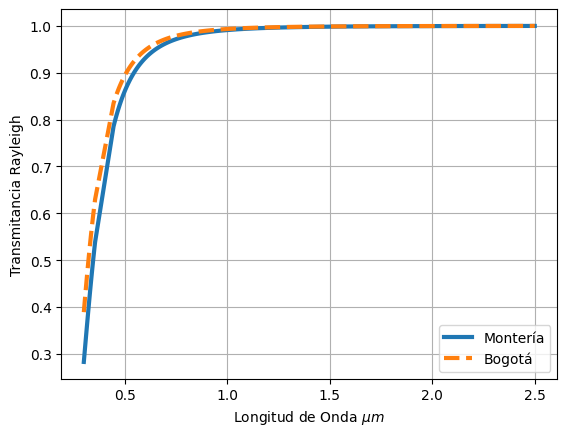

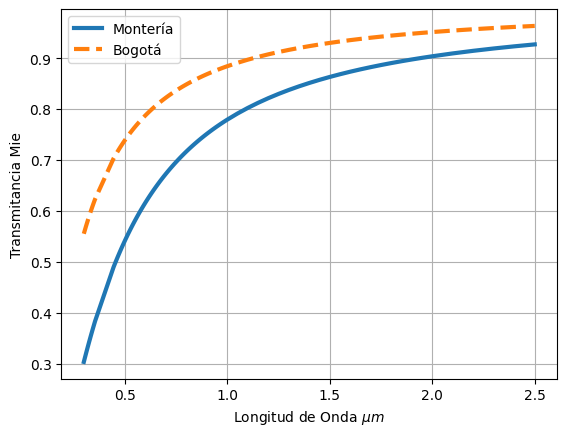

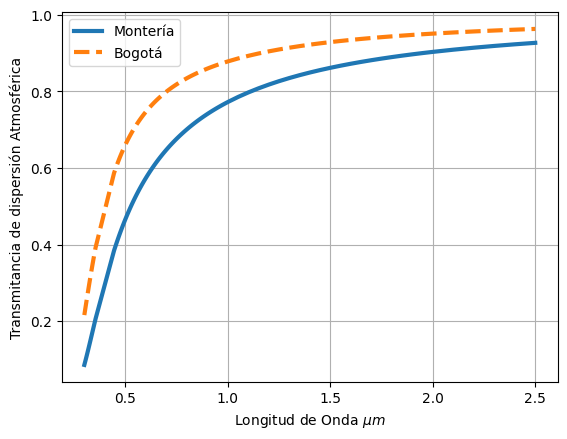

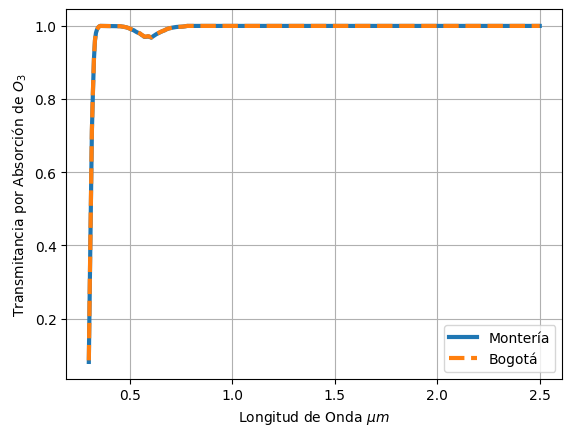

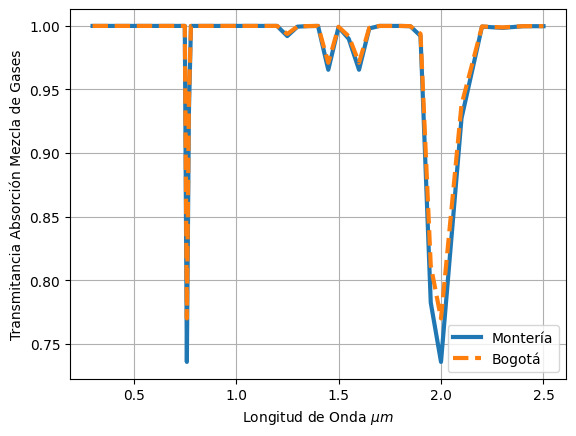

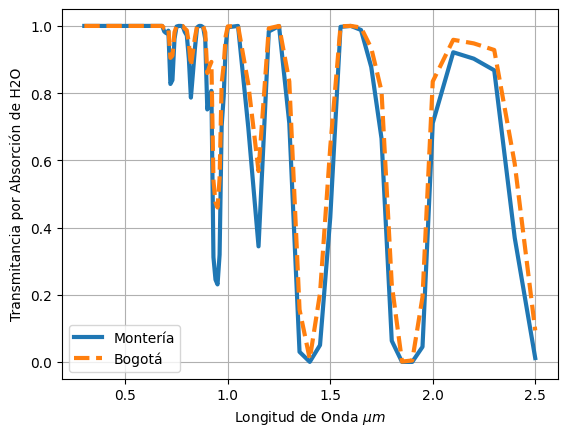

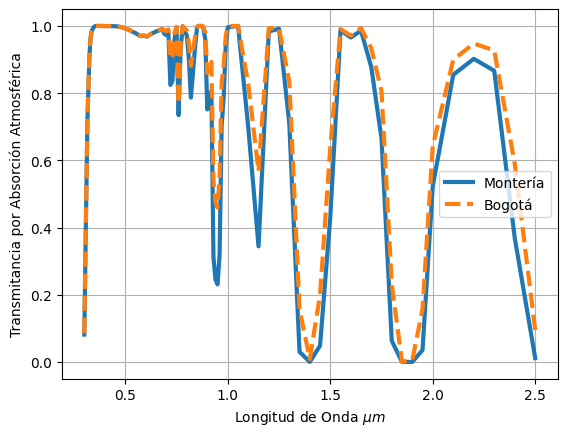

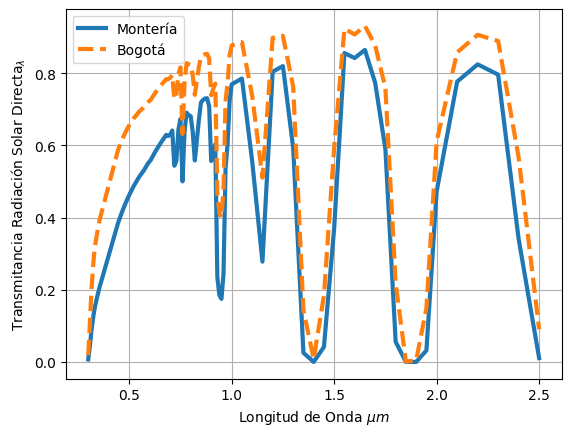

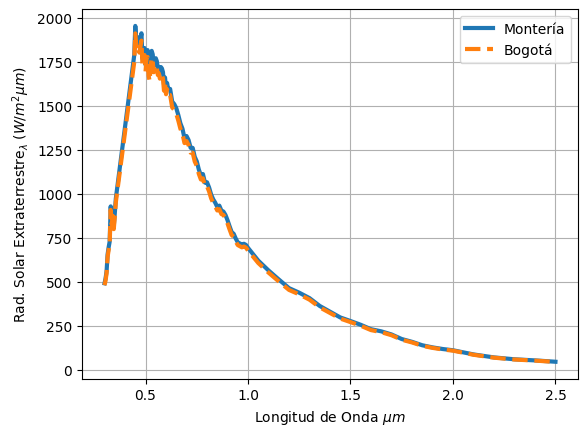

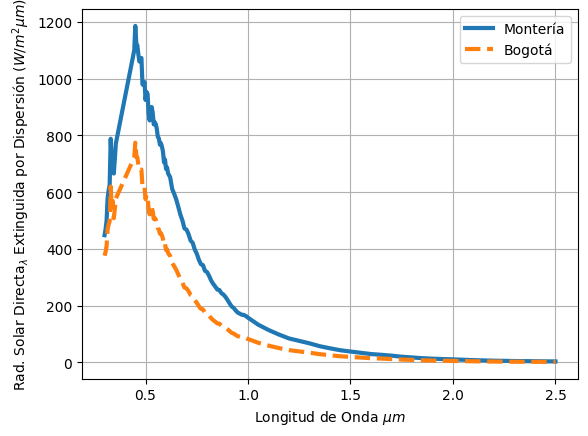

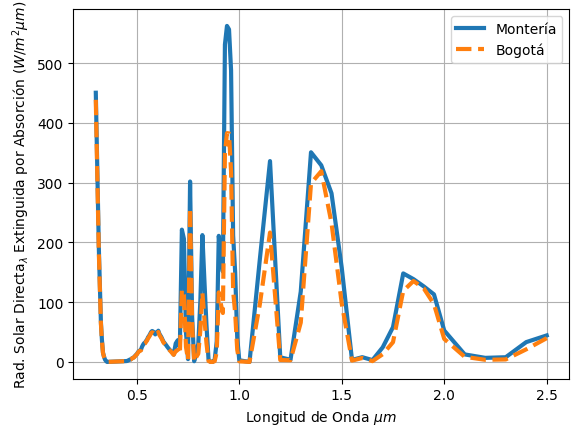

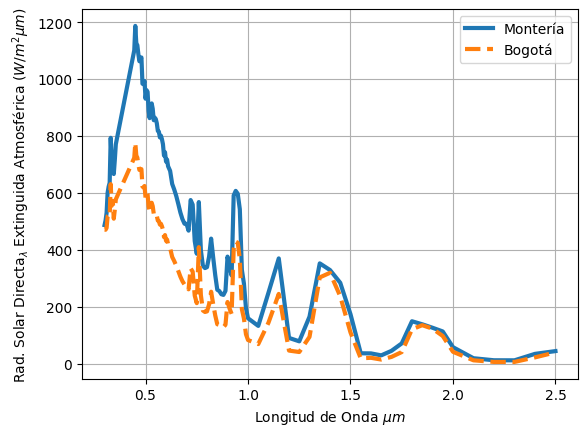

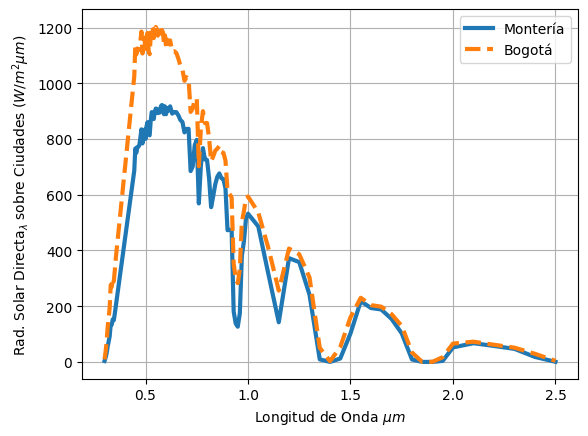

In [2]:
import matplotlib.pyplot as plt  # Herramienta para realizar gráficas

for res in resultados_monteria.keys():       
    fig, ax = plt.subplots()
    plt.xlabel(r'Longitud de Onda $\mu m$')
    plt.ylabel(f'{res}')
    plt.grid()    
    ax.plot(longitud_onda, resultados_monteria[res], "-", linewidth=3)
    ax.plot(longitud_onda, resultados_bogota[res], "--", linewidth=3)
    ax.legend(['Montería', 'Bogotá'])
    plt.savefig(f'mont_{res[:-15]}.jpg')
    plt.show()
    content_mont = tabulate({res: resultados_monteria[res], "longitud de onda (μm)":longitud_onda},headers="keys", tablefmt="psql")
    content_bogt = tabulate({res: resultados_bogota[res],  "longitud de onda (μm)":longitud_onda},headers="keys", tablefmt="psql")
    text_file=open(f"monteria_{res[:-13]}.txt","w")
    text_file.write("Montería \n")
    text_file.write(content_mont)
    text_file.close()
    text_file2=open(f"bogota_{res[:-13]}.txt","w")
    text_file2.write("Bogotá \n")
    text_file2.write(content_bogt)
    text_file2.close()
    